# Simulated data
In this script, we generate 2-cluster synthetic 1d data, and test our model on it.

First, we generate data and save it to a file named `../data/test.jld2`.

In [4]:
# include("generator.jl")

Next, load the data and run the MCMC according to some simulation settings. These configurations are written in `test2.TOML`; the simulation results are setup.

`test.TOML` has the following settings:
(TODO: fill this in; test2.TOML is just a slightly modified version of test.TOML)

In [5]:
# The following commands should be run in terminal due to progress bar display.

# config_file = "../configs/test2.TOML"
# include("MCMC.jl")
# MCMC(config_file)

In [1]:
using RCall 
using JLD2 
using Distributions 
# using LinearAlgebra

In [2]:
fitdata = load("../output/fit_test2.jld2");
simdata = load("../data/test2.jld2");
ylist_censored = simdata["y"];
ylist_orig = simdata["x"];

We plot the censored data (the first plot) and the imputed data (the green points).

In [18]:
@rput ylist_orig
@rput ylist_censored
R"""
library(tidyverse)
TT = 30

## Plot original data
x = lapply(1:TT, function(tt) rep(tt,100)) %>% do.call("c",.)
y = do.call("c", ylist_orig)
dt_orig = tibble(x=x, y=y)
g2 = ggplot(dt_orig) + geom_point(aes(x=x, y=y), col = 'green', alpha = .3) + geom_point(aes(x=x, y=y), alpha = 1, data = dt)
plot(g2)

## Plot censored data
x = lapply(1:TT, function(tt) rep(tt,100)) %>% do.call("c",.)
y = do.call("c", ylist_censored)
dt = tibble(x=x, y=y)
g = ggplot(dt) + geom_point(aes(x=x, y=y), alpha = .3) +
    geom_hline(yintercept = c(-2.5, 2.5), col = 'red')
"""

LoadError: REvalError: Error in f(...) : argument "df" is missing, with no default
Calls: plot ... lapply -> FUN -> <Anonymous> -> f -> <Anonymous> -> f

We can visualize the censoring; the green points have been censored to the red points.

In [17]:
# @rput ylist_orig
# @rput ylist_censored
# R"""
# library(tidyverse)
# TT = 30
# cut_limits = c(-3.5,3.5)


# dt = lapply(1:TT, function(tt){
#   y_censored = ylist_censored[[tt]]
#   y_orig = ylist_orig[[tt]]
#   cut = (y_censored %in% cut_limits)
#   tibble(x = tt,
#          xjitter = tt + runif(length(y_orig), -0.2, +0.2),  ## jittering the x's for visualization
#          orig = y_orig, 
#          censored = y_censored,
#          cut = cut)
# }) %>% bind_rows()
# print(dt)

# g = dt %>% subset(x <= 10) %>% ggplot() + 
# geom_point(aes(x=x, y=censored), col = 'red', data = .%>% subset(cut == 1)) +
# geom_point(aes(x=x, y=orig), alpha = .5, data = . %>% subset(cut == 0)) +
# geom_point(aes(x=x, y=orig), data = . %>% subset(cut==1), col = 'green') +
# geom_curve(aes(x = x, y = orig, xend = x, yend = censored, ),
#                   arrow = arrow(length = unit(0.2, "cm")), alpha = .5, 
#                 curvature = .3,    
#               data = . %>% subset(cut == 1)
#              ) +
# ylab("Data") +
# xlab("Time") 
# """

Next, load the MCMC results and make a plot of the imputed data; thsi reverts the censored red points back to imputed green points.

In [3]:
pos = fitdata["pos"]
hyper = fitdata["hyper"]

nsam = length(pos["sigma1"])
nburn = div(nsam, 4) # discard the first 25% samples
nthin = div(nsam-nburn,2000) # keep 2000 posterior samples for inference
# keep_index = [nburn:nthin;] ## Taknig the last guy?
keep_index = [nburn+1:nthin:nsam;];
nkeep = length(keep_index);

sigma1_save = pos["sigma1"][keep_index];
sigma2_save = pos["sigma2"][keep_index];
mu1_save = pos["mu1"][keep_index,:];
mu2_save = pos["mu2"][keep_index,:];
phi1_save = pos["phi1"][keep_index,:];
w1_save = exp.(phi1_save) ./ (exp.(phi1_save) .+ 1);

Z_save = pos["Z"][keep_index];
_y_save = pos["_y"][keep_index];

l1_save = pos["l1"][keep_index]
l2_save = pos["l2"][keep_index]
l3_save = pos["l3"][keep_index]
e1_save = pos["e1"][keep_index]
e2_save = pos["e2"][keep_index]
e3_save = pos["e3"][keep_index];

Check convergence and mixing of MCMC chains

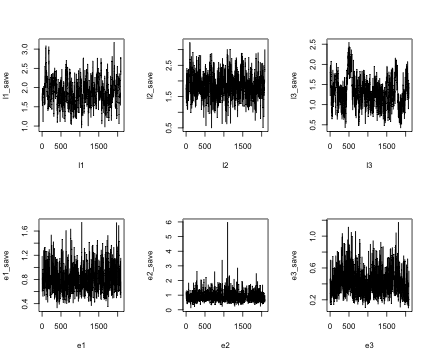

RObject{VecSxp}
$mfrow
[1] 2 3



In [4]:
@rput l1_save l2_save l3_save;
@rput e1_save e2_save e3_save;
R"""
par(mfrow=c(2,3))
plot(l1_save, type='l', xlab="l1")
plot(l2_save, type='l', xlab="l2")
plot(l3_save, type='l', xlab="l3")
plot(e1_save, type='l', xlab="e1")
plot(e2_save, type='l', xlab="e2")
plot(e3_save, type='l', xlab="e3")
par(mfrow=c(1,1))
"""

Compare prior and posterior 

In [5]:
l1_grids = range(minimum(l1_save), maximum(l1_save), length=200);
l1_dens = pdf.(Gamma(hyper["al"], hyper["bl"]), l1_grids);

l2_grids = range(minimum(l2_save), maximum(l2_save), length=200);
l2_dens = pdf.(Gamma(hyper["al"], hyper["bl"]), l2_grids);

l3_grids = range(minimum(l3_save), maximum(l3_save), length=200);
l3_dens = pdf.(Gamma(hyper["al"], hyper["bl"]), l3_grids);

e1_grids = range(minimum(e1_save), maximum(e1_save), length=200);
e1_dens = pdf.(Gamma(hyper["ae"], hyper["be"]), l1_grids);

e2_grids = range(minimum(e2_save), maximum(e2_save), length=200);
e2_dens = pdf.(Gamma(hyper["ae"], hyper["be"]), l1_grids);

e3_grids = range(minimum(e3_save), maximum(e3_save), length=200);
e3_dens = pdf.(Gamma(hyper["ae"], hyper["be"]), l1_grids);

In [6]:
@rput l1_grids l1_dens;
@rput l2_grids l2_dens;
@rput l3_grids l3_dens;
@rput e1_grids e1_dens;
@rput e2_grids e2_dens;
@rput e3_grids e3_dens;

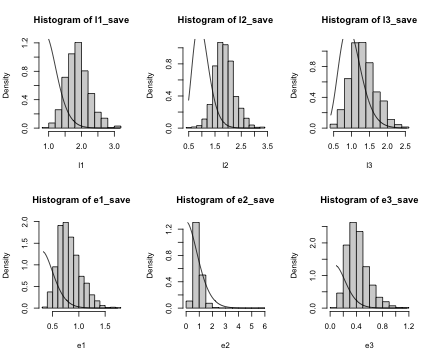

RObject{VecSxp}
$mfrow
[1] 2 3



In [7]:
R"""
par(mfrow=c(2,3))
hist(l1_save, freq=FALSE, xlab="l1")
lines(l1_dens ~ l1_grids)

hist(l2_save, freq=FALSE, xlab="l2")
lines(l2_dens ~ l2_grids)

hist(l3_save, freq=FALSE, xlab="l3")
lines(l3_dens ~ l3_grids)

hist(e1_save, freq=FALSE, xlab="e1")
lines(e1_dens ~ e1_grids)

hist(e2_save, freq=FALSE, xlab="e2")
lines(e2_dens ~ e2_grids)

hist(e3_save, freq=FALSE, xlab="e3")
lines(e3_dens ~ e3_grids)
par(mfrow=c(1,1))
"""

In [7]:
# @rput ylist_impute_mean
# R"""
# #png("imputed.png")
# #plot(x=rep(1,100), y= y_impute_mean[[1]], xlim=c(1,30), ylim=c(min(unlist(y_impute_mean)),max(unlist(y_impute_mean))), col="red", ylab="y", xlab="t")
# #for(i in 2:30)
# #{    
# #    points(x=rep(i,length(y_impute_mean[[i]])), y=y_impute_mean[[i]], col="red")
# #    # hist(y[[i]])
# #}
# #dev.off() 

# library(tidyverse)

# dt = lapply(1:TT, function(tt){
#   y_censored = ylist_censored[[tt]]
#   y_impute_mean = ylist_impute_mean[[tt]]
#   cut = (y_censored %in% cut_limits)
#   tibble(x = tt,
#          xjitter = tt + runif(length(y_impute_mean), -0.2, +0.2),  ## jittering the x's for visualization
#          impute_mean = y_impute_mean, 
#          censored = y_censored,
#          cut = cut)
# }) %>% bind_rows()
# print(dt)


# g = dt %>% subset(x <= 10) %>% ggplot() + 
# geom_point(aes(x=x, y=censored), col = 'red', data = .%>% subset(cut == 1)) +
# geom_point(aes(x=x, y=impute_mean), alpha = .5, data = . %>% subset(cut == 0)) +
# geom_point(aes(x=x, y=impute_mean), data = . %>% subset(cut==1), col = 'green') +
# geom_curve(aes(xend = x, yend = impute_mean, x = x, y = censored, ),
#                   arrow = arrow(length = unit(0.2, "cm")), alpha = .5, 
#                 curvature = .3,    
#               data = . %>% subset(cut == 1)
# ) +
# ylab("Data") +
# xlab("Time") 
# """

Next, we make a plot with the following features (TODO: actually do this)
- Cluster means ($\{\mu_{kt}, t=1,\cdots, T\}, k=1,2$) over time,
- 95% probability regions (bands) for each cluster using,
- Cluster means' thickness are proportional to the cluster probabilities ($\{\pi_{kt}, t=1,\cdots, T\}, k=1,2$).

In [15]:
using ProgressMeter
using LinearAlgebra
include("utils.jl");

In [17]:
T_grids = range(1, 30, length=300)

T = 30
nrep = 100
mu1_pos = zeros(nkeep, length(T_grids), nrep)
@showprogress for i in (1:nkeep)
    Kvv = get_dist_matrix(1:T, 1:T, l1_save[i], e1_save[i])
    Kwv = get_dist_matrix(T_grids, 1:T, l1_save[i], e1_save[i])
    Kww = get_dist_matrix(T_grids, T_grids, l1_save[i], e1_save[i])

    Kvv_inv = svd2inv(Kvv)
    mean = Kwv * Kvv_inv * mu1_save[i,:]
    Cov = Kww - Kwv * Kvv_inv * Kwv'
    if !isposdef(Cov)
        Cov = (Cov + Cov') / 2
        Cov = Cov + Matrix(Diagonal(10e-7 .* ones(length(T_grids)))) 
    end 
    mu1_pos[i,:,:] = rand(MvNormal(mean, Cov), nrep)
end

mu2_pos = zeros(nkeep, length(T_grids), nrep)
@showprogress for i in (1:nkeep)
    Kvv = get_dist_matrix(1:T, 1:T, l2_save[i], e2_save[i])
    Kwv = get_dist_matrix(T_grids, 1:T, l2_save[i], e2_save[i])
    Kww = get_dist_matrix(T_grids, T_grids, l2_save[i], e2_save[i])

    Kvv_inv = svd2inv(Kvv)
    mean = Kwv * Kvv_inv * mu2_save[i,:]
    Cov = Kww - Kwv * Kvv_inv * Kwv'
    if !isposdef(Cov)
        Cov = (Cov + Cov') / 2
        Cov = Cov + Matrix(Diagonal(10e-7 .* ones(length(T_grids)))) 
    end 
    mu2_pos[i,:,:] = rand(MvNormal(mean, Cov), nrep)
end

mu1_truth = 0.5 .* sin.(T_grids) .+ 1;
mu2_truth = 0.5 .* cos.(T_grids) .- 1;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [21]:
@rput mu1_truth  mu2_truth
@rput mu1_pos  mu2_pos  
@rput T_grids;

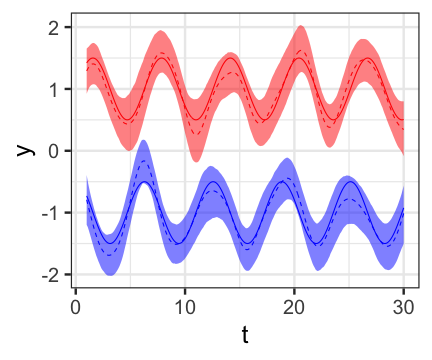

RObject{VecSxp}


In [24]:
R"""
library(ggplot2)
mu1_pos_mean = apply(mu1_pos, 2, mean)
mu1_pos_quan = apply(mu1_pos, 2, quantile, prob=c(0.025, 0.975))
mu2_pos_mean = apply(mu2_pos, 2, mean)
mu2_pos_quan = apply(mu2_pos, 2, quantile, prob=c(0.025, 0.975))

mu_pos_df = data.frame(x=T_grids, l1=mu1_pos_quan[1,], h1=mu1_pos_quan[2,], m1=mu1_pos_mean, t1=mu1_truth, 
                                  l2=mu2_pos_quan[1,], h2=mu2_pos_quan[2,], m2=mu2_pos_mean, t2=mu2_truth)
p_pos_mu = ggplot(mu_pos_df) 
p_pos_mu = p_pos_mu + geom_ribbon(aes(x=x,ymin=l1,ymax=h1), fill="red", alpha=0.5)
p_pos_mu = p_pos_mu + geom_line(aes(x=x,y=m1), color="red", linetype="dashed")
p_pos_mu = p_pos_mu + geom_line(aes(x=x,y=t1), color="red")
p_pos_mu = p_pos_mu + geom_ribbon(aes(x=x,ymin=l2,ymax=h2), fill="blue", alpha=0.5)
p_pos_mu = p_pos_mu + geom_line(aes(x=x,y=m2), color="blue", linetype="dashed")
p_pos_mu = p_pos_mu + geom_line(aes(x=x,y=t2), color="blue")
p_pos_mu = p_pos_mu + xlab("t") + ylab("y") + theme_bw(base_size=25)
p_pos_mu
"""

In [26]:
w_pos = zeros(nkeep, length(T_grids), nrep)
@showprogress for i in (1:nkeep)
    Kvv = get_dist_matrix(1:T, 1:T, l3_save[i], e3_save[i])
    Kwv = get_dist_matrix(T_grids, 1:T, l3_save[i], e3_save[i])
    Kww = get_dist_matrix(T_grids, T_grids, l3_save[i], e3_save[i])

    Kvv_inv = svd2inv(Kvv)
    mean = Kwv * Kvv_inv * phi1_save[i,:]
    Cov = Kww - Kwv * Kvv_inv * Kwv'
    if !isposdef(Cov)
        Cov = (Cov + Cov') / 2
        Cov = Cov + Matrix(Diagonal(10e-7 .* ones(length(T_grids)))) 
    end 
    phi1 = rand(MvNormal(mean, Cov), nrep)
    w_pos[i,:,:] = exp.(phi1) ./ (exp.(phi1) .+ 1)
end

w_truth = 0.5 .* ones(length(T_grids));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


In [27]:
@rput w_pos w_truth; 

In [ ]:
R"""
library(ggplot2)
w_pos_mean = apply(w_pos, 2, mean)
w_pos_quan = apply(w_pos, 2, quantile, prob=c(0.025, 0.975))

w_pos_df = data.frame(x=T_grids, l1=w_pos_quan[1,], h1=w_pos_quan[2,], m1=w_pos_mean, t1=w_truth)
p_pos_w = ggplot(w_pos_df) 
p_pos_w = p_pos_mu + geom_ribbon(aes(x=x,ymin=l1,ymax=h1), fill="red", alpha=0.5)
p_pos_w = p_pos_mu + geom_line(aes(x=x,y=m1), color="red", linetype="dashed")
p_pos_w = p_pos_mu + geom_line(aes(x=x,y=t1), color="red")
p_pos_mu = p_pos_mu + geom_ribbon(aes(x=x,ymin=l2,ymax=h2), fill="blue", alpha=0.5)
p_pos_mu = p_pos_mu + geom_line(aes(x=x,y=m2), color="blue", linetype="dashed")
p_pos_mu = p_pos_mu + geom_line(aes(x=x,y=t2), color="blue")
p_pos_mu = p_pos_mu + xlab("t") + ylab("y") + theme_bw(base_size=25)
p_pos_mu
"""

Next, we plot the true cluster probabilities against the estimated ones.

Next, we plot the imputed data.

We shorten the distance between the two cluster means (TODO: one setup is for when the cluster means touch but don't cross; another setup is for when cluster means actually cross).

We also compare it against several other competing methods. The main competitor is a 2-cluster Gaussian mixture model applied to each timepoint separately. At each time point, the cluster with the higher mean $\mu_{kt}$ is called cluster 2, and the other one is cluster 1. The analyses are repeated with this model.